In [28]:
import sys
import random
import numpy as np
import pandas as pd
import numpy as np
import json
import matplotlib.pylab as plt
%matplotlib inline
import ipyvolume as ipv

from IPython.display import Image
from scipy import optimize

from tyssue import config, Sheet, SheetGeometry, History, EventManager
from tyssue import SheetGeometry as geom
from tyssue import PlanarGeometry as geom
from tyssue.draw.plt_draw import create_gif
from tyssue.draw.plt_draw import plot_forces
from tyssue.draw import sheet_view
from tyssue.dynamics import effectors, model_factory
from tyssue.dynamics import PlanarModel
from tyssue.dynamics import SheetModel as model
from tyssue.generation import three_faces_sheet
from tyssue.solvers.viscous import EulerSolver
from tyssue.solvers.quasistatic import QSSolver
from tyssue.draw import sheet_view
from tyssue.draw.plt_draw import plot_forces
from tyssue.io import hdf5
import copy

from tyssue.draw import sheet_view
from tyssue import config
from tyssue import Monolayer, config, MonolayerGeometry
from tyssue.generation import extrude


from tyssue.geometry.planar_geometry import PlanarGeometry as geom
from tyssue.solvers.quasistatic import QSSolver
from tyssue.dynamics.planar_vertex_model import PlanarModel as model


from tyssue.stores import load_datasets

from tyssue.topology.sheet_topology import remove_face, cell_division

import warnings
warnings.filterwarnings('ignore')


In [29]:
def change_specs(cellmap_original, geom_original, model_original, history_original, face_elasticity,
                 prefered_area, line_tension_FRC, line_tension_ECM, endTime):
    
   
    cellmap_original.update_specs(config.dynamics.quasistatic_plane_spec())
    #history_original = History(cellmap_original, extra_cols={"edge":["dx", "dy"]})

    cellmap_original.face_df["face_elasticity"] = face_elasticity
    cellmap_original.face_df["prefered_area"] = cellmap_original.face_df["area"].mean()*prefered_area

    cellmap_original.vert_df["viscosity"] = 1    
    cellmap_original.edge_df["line_tension"] = line_tension_FRC + line_tension_ECM
    
    cellmap_original.face_df["perimeter_elasticity"] = 0
    cellmap_original.face_df["contractility"] = 0
    
    
    solver1 = EulerSolver(cellmap_original, geom_original, model_original, history=history_original, auto_reconnect=True)
    res1 = solver1.solve(tf=endTime, dt=0.05)
    
    cellmap_new = copy.deepcopy(cellmap_original)
    geom_new = copy.deepcopy(geom_original)
    model_new = copy.deepcopy(model_original)
    history_new = copy.deepcopy(history_original)
    
    return [cellmap_new, geom_new, model_new, history_new]
    

In [30]:
## Definition of the sheet
geom  = SheetGeometry # This may need to change
model = PlanarModel # This may need to change
cellmap = Sheet.planar_sheet_3d('cellmap', 7, 7, 1, 1) # This may need to change
cellmap.sanitize ( trim_borders=True, order_edges=True )
geom.update_all(cellmap)

history = History(cellmap, extra_cols={"edge":["dx", "dy"]})


## Phase: Homeostasis

8.007150793517669


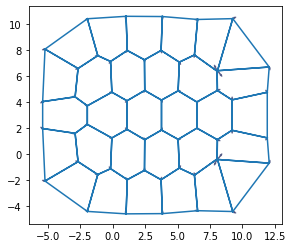

In [10]:
change_specs(cellmap, geom, model, history, 5, 10, 0.4, 0.4, 10)
fig, ax = plot_forces(cellmap, geom, model, ['x', 'y'], 1)
print(cellmap.face_df["area"].mean())

In [21]:
cellmap.edge_df

,trgt,nz,length,face,srce,dx,dy,sx,sy,tx,...,uy,uz,is_valid,rx,ry,rz,phi,sub_area,sub_vol,line_tension
edge,,,,,,,,,,,,,,,,,,,,,
0,27,4.061495,2.950076,0,4,0.802911,2.838711,-1.943713,-4.418646,-1.140803,...,0.962250,0.0,True,0.793835,-2.251842,0.0,-1.030377,2.030747,-8.122990,0.8
1,25,2.473423,1.813800,0,27,-1.519404,0.990597,-1.140803,-1.579935,-2.660207,...,0.546145,0.0,True,1.596745,0.586869,0.0,0.321751,1.236711,-4.946845,0.8
2,1,3.899829,2.949294,0,25,-2.545262,-1.489960,-2.660207,-0.589338,-5.205469,...,-0.505192,0.0,True,0.077341,1.577466,0.0,1.892547,1.949915,-7.799659,0.8
3,4,5.487901,4.013926,0,1,3.261755,-2.339349,-5.205469,-2.079297,-1.943713,...,-0.582808,0.0,True,-2.467921,0.087507,0.0,2.944197,2.743951,-10.975803,0.8
4,22,5.324320,2.986739,1,4,2.980767,-0.188775,-1.943713,-4.418646,1.037054,...,-0.063204,0.0,True,-1.730089,-1.676657,0.0,-2.356194,2.662160,-10.648641,0.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
151,37,5.811603,2.708840,28,41,-2.708092,-0.063653,9.255751,10.427419,6.547658,...,-0.023498,0.0,True,1.608185,2.183813,0.0,0.785398,2.905802,-11.623206,0.8
152,36,3.526471,2.744784,28,37,-0.245037,-2.733824,6.547658,10.363767,6.302622,...,-0.996007,0.0,True,-1.099908,2.120161,0.0,2.356194,1.763235,-7.052942,0.8
153,5,5.215917,3.995174,29,6,3.985015,0.284730,8.077824,6.416608,12.062839,...,0.071268,0.0,True,-1.720980,-1.431847,0.0,-2.356194,2.607958,-10.431833,0.8


In [33]:
draw_specs = cellmap.config.draw.sheet_spec()
draw_specs['edge']['visible'] = True

AttributeError: 'Sheet' object has no attribute 'config'

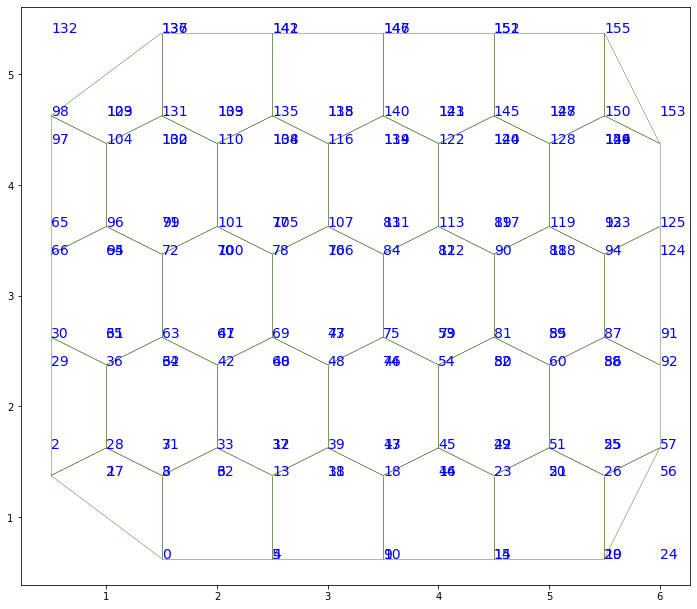

In [43]:
fig, ax = sheet_view(cellmap)
fig.set_size_inches(12, 12)



for edge, data in cellmap.edge_df.iterrows():
    ax.text(data.tx, data.sy, edge, fontsize=14, color="b")


In [55]:
random.randrange(1, 5)

3

In [90]:
edge_line_tension = cellmap.edge_df['line_tension']
edge_line_tension

edge
0      1
1      1
2      1
3      1
4      1
      ..
151    1
152    1
153    1
154    1
155    1
Name: line_tension, Length: 156, dtype: int64

In [91]:
for edge in range(len(cellmap.edge_df)):
    cellmap.edge_df['line_tension'] = random.randrange(1, 5)

In [92]:
cellmap.edge_df

,trgt,nz,length,face,srce,dx,dy,sx,sy,tx,...,uy,uz,is_valid,rx,ry,rz,phi,sub_area,sub_vol,line_tension
edge,,,,,,,,,,,,,,,,,,,,,
0,27,4.061495,2.950076,0,4,0.802911,2.838711,-1.943713,-4.418646,-1.140803,...,0.962250,0.0,True,0.793835,-2.251842,0.0,-1.030377,2.030747,-8.122990,2
1,25,2.473423,1.813800,0,27,-1.519404,0.990597,-1.140803,-1.579935,-2.660207,...,0.546145,0.0,True,1.596745,0.586869,0.0,0.321751,1.236711,-4.946845,2
2,1,3.899829,2.949294,0,25,-2.545262,-1.489960,-2.660207,-0.589338,-5.205469,...,-0.505192,0.0,True,0.077341,1.577466,0.0,1.892547,1.949915,-7.799659,2
3,4,5.487901,4.013926,0,1,3.261755,-2.339349,-5.205469,-2.079297,-1.943713,...,-0.582808,0.0,True,-2.467921,0.087507,0.0,2.944197,2.743951,-10.975803,2
4,22,5.324320,2.986739,1,4,2.980767,-0.188775,-1.943713,-4.418646,1.037054,...,-0.063204,0.0,True,-1.730089,-1.676657,0.0,-2.356194,2.662160,-10.648641,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
151,37,5.811603,2.708840,28,41,-2.708092,-0.063653,9.255751,10.427419,6.547658,...,-0.023498,0.0,True,1.608185,2.183813,0.0,0.785398,2.905802,-11.623206,2
152,36,3.526471,2.744784,28,37,-0.245037,-2.733824,6.547658,10.363767,6.302622,...,-0.996007,0.0,True,-1.099908,2.120161,0.0,2.356194,1.763235,-7.052942,2
153,5,5.215917,3.995174,29,6,3.985015,0.284730,8.077824,6.416608,12.062839,...,0.071268,0.0,True,-1.720980,-1.431847,0.0,-2.356194,2.607958,-10.431833,2


In [18]:
cellmap.edge_df['line_tension'] = random.randrange(1, 5)

In [22]:
range(len(cellmap.edge_df))

range(0, 156)

edge
0      0.28125
1      0.15625
2      0.21875
3      0.34375
4      0.50000
        ...   
151    0.50000
152    0.37500
153    0.12500
154    0.12500
155    0.12500
Name: nz, Length: 156, dtype: float64

In [79]:
for edge in range(len(cellmap.edge_df)):
    #print(cellmap.edge_df['line_tension'][edge])
    newValue = random.randrange(1, 5)/10
    cellmap.edge_df['line_tension'][edge] = newValue
    #print(cellmap.edge_df['line_tension'][edge])

In [80]:
cellmap.edge_df['line_tension']

edge
0      0.2
1      0.1
2      0.4
3      0.3
4      0.4
      ... 
151    0.1
152    0.2
153    0.3
154    0.2
155    0.2
Name: line_tension, Length: 156, dtype: float64